## Creating a model and building

We will be building a neural network in pytorch. we will be using `torch.nn` for this task

In [126]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets,transforms 

In [127]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
device

'cpu'

### Defining the neural network class

Lets create a Neural class, that takes input of image size 28*28 and produces forward pass output passed through relu activiated two layers.

In [128]:
class Neural(nn.Module):
    def __init__(self) :
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_layers = nn.Sequential(
            nn.Linear(28*28 , 512),
            nn.ReLU(),
            nn.Linear(512,512),
            nn.ReLU(),
            nn.Linear(512,10),
        )

    def forward(self,x):
        x = self.flatten(x)
        logits = self.linear_layers(x)
        return logits

`nn.Flatten` does similar to what `np.flatten` does. It flattens out high dimensional data to a single dimension.  

In [129]:
random_images = torch.rand(3,28,28)
flattener = nn.Flatten()
flattened_output =  flattener(random_images)
flattened_output.shape

torch.Size([3, 784])

We can see the `nn.Flatten()` maintained the dimension `0`. If we want to flatten all the dimension it can be done as 

In [130]:
all_flattened = nn.Flatten(start_dim=0, end_dim= -1)(random_images)
all_flattened.shape

torch.Size([2352])

Another layer is the `nn.Linear`. It applies a linear transformation to the input with its strored weight. Lets see the result.

In [131]:
linear_transformer = nn.Linear(in_features= 28*28 , out_features = 1 )
linear_output = linear_transformer(flattened_output)
linear_output.shape

torch.Size([3, 1])

It produces output of three random images data. Lets see the weight 

In [132]:
linear_transformer.weight[0,:20]

tensor([ 0.0084,  0.0268, -0.0272, -0.0034,  0.0301,  0.0123,  0.0088,  0.0163,
         0.0015,  0.0108,  0.0120,  0.0250, -0.0353,  0.0132,  0.0314, -0.0161,
        -0.0232, -0.0316,  0.0037,  0.0003], grad_fn=<SliceBackward0>)

In [133]:
linear_transformer.weight.shape

torch.Size([1, 784])

And another is nn.ReLU , it just applies relu function to the input.

![relu](./images/relu.png)

To combine all the function together, we use Sequential. the data will be passed in the order as defined.

Now lets create a model and compute the `forward pass`

In [134]:
model = Neural().to(device)
print(model)

Neural(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_layers): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


I have created two random images, one is a random numpy array and another is random tensor. When we pass the random image to the model.flatten(). We can see that the numpy array isn't supported so we must pass tensor to the function. And the `device` the tensor is created should also match.

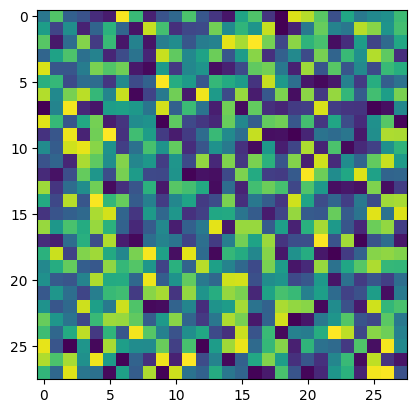

In [135]:
import numpy as np
import matplotlib.pyplot as plt

Y = np.random.rand(1,28,28) # we can't pass this to torch flatten function. We need a tensor
X = torch.rand(1, 28, 28, device=device)
plt.imshow(X[0])

In [136]:
input_to_model = model.flatten(X)
input_to_model.shape

torch.Size([1, 784])

In [137]:
final_output = model.linear_layers(input_to_model)
final_output.shape

torch.Size([1, 10])

Thus our random image, final output is the output of the 10 final units. Now if we are doing a classification task we pass it to the softmax function

In [138]:
final_probability = nn.Softmax(dim= 1)(final_output)
print(final_probability)

tensor([[0.1087, 0.0978, 0.1009, 0.1058, 0.0985, 0.0944, 0.1000, 0.0938, 0.1041,
         0.0960]], grad_fn=<SoftmaxBackward0>)


In [139]:
final_probability.shape

torch.Size([1, 10])

We get a tensor that contains our probability of each class. So lets ge the index of max probability

In [140]:
predicted_class = final_probability.argmax(1)
predicted_class

tensor([0])

## Automatic  Differentitation with torch.autograd

We know once we do forward pass, we get the output now to update the weights of the Linear layers, which we saw earlier. For each layer there is weight connecting the previous nodes and current nodes as well as there are bias terms. To update them we take derivative of the `Cost` function with the weights and calulate the gradient which will be further used to update them.


To do this , pytorch has differentiation calulation enginer called torch.autograd which automatically computes the gradient for the computation graph.

Lets peform a simple forward pass, which will be based on the fig shown below :

![computation_graph](./images/computation_graph.png)

Lets assume the input consist of data having 5 feature.

And there is only one output node

![perceptron_image](./images/perceptorn.png)


We will conside the activation function to be just linear in this case

In [141]:
x = torch.rand(1,5)
w = torch.rand(5,1 ,requires_grad= True )
b = torch.rand(1 , requires_grad= True)
z = x @ w + b

Lets say our actual target is `y` = 1.5. and lets take absolute error as loss metric

In [142]:
y = torch.tensor(1.5)
loss = y - z

Now if we want to find the gradient of `w` and `b` with the obtained loss. It can be done through loss.backward() . It calculates the $`\frac{\partial L}{\partial w}`$ and $`\frac{\partial L}{\partial b}`$

In [143]:
loss.backward()

Lets see the gradients of the weight matrix.

In [144]:
w.grad

tensor([[-0.0905],
        [-0.3120],
        [-0.2455],
        [-0.0203],
        [-0.0054]])

Similarly lets see the gradients of the bias matrix

In [145]:
b.grad

tensor([-1.])

Note 
> 
    We can only obtain the grad properties for the leaf nodes of the computational graph, which have requires_grad property set to True. For all other nodes in our graph, gradients will not be available.

    We can only perform gradient calculations using backward once on a given graph, for performance reasons. If we need to do several backward calls on the same graph, we need to pass retain_graph=True to the backward call.


Once we train the network, we only need to predict. So, we no longer need to calculate the gradient .Thus, we do the following :

In [146]:
z = torch.matmul(x, w)+b
print(z.requires_grad)

with torch.no_grad():
    z = torch.matmul(x, w)+b
print(z.requires_grad)

True
False


We can use `z.detach()` as well to make the `requires_grad` set to `False`.

### Tensor Gradients and Jacobian Matrix

If we have output function as arbitrary tensor instead of scalar loss funciton. In this case , we can calulate the jacobian product instead of the actual gradient.

For a vector function \(\vec{y} = f(\vec{x})\), where \(\vec{x} = \langle x_1, \ldots, x_n \rangle\) and \(\vec{y} = \langle y_1, \ldots, y_m \rangle\), a gradient of \(\vec{y}\) with respect to \(\vec{x}\) is given by the **Jacobian matrix**:

```math
J = \begin{pmatrix}
\frac{\partial y_1}{\partial x_1} & \cdots & \frac{\partial y_1}{\partial x_n} \\
\vdots & \ddots & \vdots \\
\frac{\partial y_m}{\partial x_1} & \cdots & \frac{\partial y_m}{\partial x_n}
\end{pmatrix}
```

Instead of computing the Jacobian matrix itself, PyTorch allows you to compute the **Jacobian Product** \(\vec{v}^T \cdot J\) for a given input vector \(\vec{v} = \langle v_1, \ldots, v_m \rangle\). This is achieved by calling `backward` with \(\vec{v}\) as an argument. The size of \(\vec{v}\) should be the same as the size of the original tensor, with respect to which we want to compute the product.
```

 

In [147]:
inp = torch.eye(4, 5, requires_grad=True)
inp

tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.]], requires_grad=True)

The function is $`y = f(x) =  (x+1)^2  `$. Now to theoritically check the gradient value.   

if we take differentiation the derivative function is $`y' = f'(x) =  2*(x+1)  `$

In [148]:
out = (inp+1).pow(2)
out

tensor([[4., 1., 1., 1., 1.],
        [1., 4., 1., 1., 1.],
        [1., 1., 4., 1., 1.],
        [1., 1., 1., 4., 1.]], grad_fn=<PowBackward0>)

In [149]:
out.backward(torch.ones_like(out), retain_graph=True)
print(f"First call\n{inp.grad}")

First call
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])


Thus gradient is calculated properly, for the first element value was 1. Its output was 4 and its gradient was 4 , which is correct.

In [150]:
out.backward(torch.ones_like(out), retain_graph=True)
print(f"\nSecond call\n{inp.grad}")


Second call
tensor([[8., 4., 4., 4., 4.],
        [4., 8., 4., 4., 4.],
        [4., 4., 8., 4., 4.],
        [4., 4., 4., 8., 4.]])


In the above we are passing new input which is all one. i.e

In [151]:
torch.ones_like(out)

tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])

In [152]:
inp.grad.zero_()
out.backward(torch.ones_like(out), retain_graph=True)
print(f"\nCall after zeroing gradients\n{inp.grad}")



Call after zeroing gradients
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])


So each time we call the backward, the gradient are accumulated. if we do retain_graph